In [1]:
import os
import glob
import hydromt
from hydromt import DataCatalog
import xarray as xr
import numpy as np
from os.path import join
import geopandas as gpd
import pandas as pd
from hydromt_sfincs import SfincsModel, utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors, patheffects
from string import ascii_lowercase as abcd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

In [ ]:
'''
Author: LEG
Date: 8/28/2024

This script is used to SFINCS related plots:
(1) Study area map of model
(2) water level timeseries and map of location
(3) total precip and max wind speed across the domain for a given storm

'''

In [3]:
# Load in model and data catalog
cat_dir = r'Z:\users\lelise\data'
yml_base_CONUS = os.path.join(cat_dir, 'data_catalog_BASE_CONUS.yml')
yml_base_Carolinas = os.path.join(cat_dir, 'data_catalog_BASE_Carolinas.yml')
yml_sfincs_Carolinas = os.path.join(cat_dir, 'data_catalog_SFINCS_Carolinas.yml')

os.chdir(r'Z:\users\lelise\projects\Carolinas_SFINCS\Chapter1_FlorenceValidation\sfincs_models\mod_v4_flor')
model_root = 'ENC_200m_sbg5m_avgN_adv1_eff75'
mod = SfincsModel(root=model_root, mode='r', data_libs=[yml_base_CONUS, yml_base_Carolinas, yml_sfincs_Carolinas])
cat = mod.data_catalog

In [7]:
# Plotting the data on a map with contextual layers
# You only need to load these once and it might take a while
load_lyrs = True
if load_lyrs is True:
    l_gdf = cat.get_geodataframe(
        r'Z:\users\lelise\data\geospatial\hydrography\nhd\NHD_H_North_Carolina_State_Shape\Shape\WBDHU6.shp')
    l_gdf = l_gdf[l_gdf['Name'].isin(['Pamlico', 'Neuse', 'Onslow Bay', 'Cape Fear', 'Lower Pee Dee', 'Upper Pee Dee'])]
    l_gdf.to_crs(epsg=32617, inplace=True)
    l_gdf.set_index('Name', inplace=True)
    basins = l_gdf

    l_gdf = cat.get_geodataframe('carolinas_major_rivers')
    l_gdf.to_crs(epsg=32617, inplace=True)
    major_rivers = l_gdf.clip(basins)

    # l_gdf = cat.get_geodataframe(r'Z:\users\lelise\data\geospatial\fris\bathy_v5\NHDArea_LowerPeeDee.shp')
    # l_gdf.to_crs(epsg=32617, inplace=True)
    # lpd_riv = l_gdf.clip(basins)

    l_gdf = cat.get_geodataframe(r'Z:\users\lelise\data\geospatial\infrastructure\enc_major_cities.shp')
    l_gdf = l_gdf[l_gdf['Name'].isin(
        ['Myrtle Beach', 'Wilmington', 'Raleigh'])]
    l_gdf.set_index('Name', inplace=True)
    l_gdf.to_crs(epsg=32617, inplace=True)
    cities = l_gdf #.clip(basins)

    l_gdf = cat.get_geodataframe(r'Z:\users\lelise\data\geospatial\infrastructure\enc_major_reservoirs.shp')
    l_gdf.set_index('Name', inplace=True)
    l_gdf.to_crs(epsg=32617, inplace=True)
    reservoirs = l_gdf.clip(basins)

    l_gdf = cat.get_geodataframe(
        r'Z:\users\lelise\data\geospatial\boundary\us_boundary\cb_2018_us_state_500k\cb_2018_us_state_500k.shp')
    l_gdf = l_gdf[l_gdf['NAME'].isin(['South Carolina', 'North Carolina'])]
    l_gdf.to_crs(epsg=32617, inplace=True)
    l_gdf.set_index('NAME', inplace=True)
    states = l_gdf

    l_gdf = cat.get_geodataframe(
        r'Z:\users\lelise\data\geospatial\infrastructure\tl_2019_us_primaryroads\tl_2019_us_primaryroads.shp')
    l_gdf = l_gdf[l_gdf['FULLNAME'].isin(['I- 95'])]
    l_gdf.to_crs(epsg=32617, inplace=True)
    roads = l_gdf.clip(states.total_bounds)

    l_gdf = cat.get_geodataframe('levees_carolinas')
    l_gdf.to_crs(epsg=32617, inplace=True)
    levees = l_gdf.clip(basins)

    l_gdf = cat.get_geodataframe('carolinas_coastal_wb')
    l_gdf.to_crs(epsg=32617, inplace=True)
    coastal_wb = l_gdf.clip(basins)

    tc_tracks = cat.get_geodataframe(r'Z:\users\lelise\data\geospatial\hurricane_tracks\IBTrACS.NA.list'
                                     r'.v04r00.lines\IBTrACS.NA.list.v04r00.lines.shp')
    tc_tracks.to_crs(epsg=32617, inplace=True)

In [15]:
# Format font for all plots
font = {'family': 'Arial', 'size': 10}
mpl.rc('font', **font)
mpl.rcParams.update({'axes.titlesize': 10})

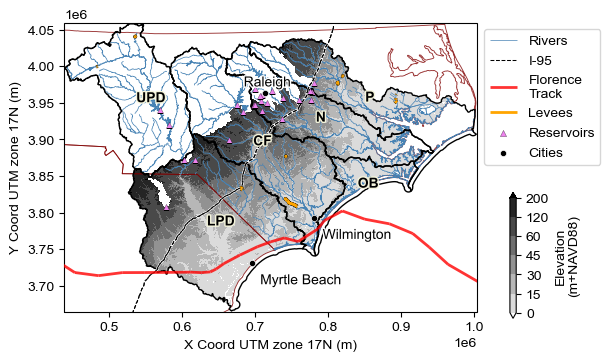

In [17]:
''' Study Area Figure '''
# Colormap for the elevation data
cmap = mpl.cm.binary
bounds = [0, 15, 30, 45, 60, 120, 200]  # elevation group in meters
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

# CRS information and extent of plot
wkt = mod.grid['dep'].raster.crs.to_wkt()
utm_zone = mod.grid['dep'].raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
extent = np.array(basins.buffer(1000).total_bounds)[[0, 2, 1, 3]]

# Now plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.2, 4.5), subplot_kw={'projection': utm}, tight_layout=True)

# Load DEM for plotting
dem = mod.grid['dep'].plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, zorder=1)

# Plot background/geography layers
states.plot(ax=ax, label='States', color='none', edgecolor='maroon', linewidth=0.65, linestyle='-', zorder=2, alpha=0.8)
major_rivers.plot(ax=ax, label='Rivers', color='steelblue', edgecolor='none', linewidth=0.5, linestyle='-', zorder=3, alpha=1)
# lpd_riv.plot(ax=ax, label='Rivers', color='steelblue', edgecolor='steelblue', linewidth=0.5, linestyle='-', zorder=3, alpha=1)
basins.plot(ax=ax, color='none', label='HUC6 Basins', edgecolor='black', linewidth=1, linestyle='-', zorder=3, alpha=1)
roads.plot(ax=ax, color='white', edgecolor='none', linewidth=1.5, linestyle='-', zorder=3, alpha=1)
roads.plot(ax=ax, color='black', edgecolor='none', linewidth=0.75, linestyle='--', zorder=3, alpha=1, label='I-95')

# Plot Hurricanes Florence and/or Matthew Tracks NHC
tc_tracks[(tc_tracks['NAME'] == 'FLORENCE') & (tc_tracks['SEASON'] == 2018)].plot(ax=ax, color='red',
                                                                                  edgecolor='none',
                                                                                  label='Florence\nTrack',
                                                                                  linewidth=2, linestyle='-',
                                                                                  zorder=3, alpha=0.80)
# tc_tracks[(tc_tracks['NAME'] == 'MATTHEW') & (tc_tracks['SEASON'] == 2016)].plot(ax=ax, color='blue',
#                                                                                  edgecolor='none',
#                                                                                  label='Matthew\nTrack NHC',
#                                                                                  linewidth=2, linestyle='-',
#                                                                                  zorder=3, alpha=0.80)

# Plot additional infrastructure
levees.plot(ax=ax, color='black', edgecolor='none', linewidth=2.5, linestyle='-', zorder=3, alpha=1)
levees.plot(ax=ax, color='orange', edgecolor='none', linewidth=2, linestyle='-', zorder=3, alpha=1, label='Levees')
reservoirs.plot(ax=ax, marker='^', markersize=20, color="violet", edgecolor='black', linewidth=0.2, label='Reservoirs', zorder=4)
cities.plot(ax=ax, marker='o', markersize=20, color="black", edgecolor='white', linewidth=0.5, label='Cities', zorder=4)

# Label Cities
for label, grow in cities.iterrows():
    x, y = grow.geometry.x, grow.geometry.y
    if label == 'Raleigh':
        ann_kwargs = dict(
            xytext=(-15, 5),
            textcoords="offset points",
            zorder=4,
            path_effects=[
                patheffects.Stroke(linewidth=2, foreground="w", alpha=1),
                patheffects.Normal(), ], )
    else:
        ann_kwargs = dict(
            xytext=(6, -15),
            #xytext=(-50, 5),
            textcoords="offset points",
            zorder=4,
            path_effects=[
                patheffects.Stroke(linewidth=2, foreground="white", alpha=1),
                patheffects.Normal(), ], )
    ax.annotate(f'{label}', xy=(x, y), **ann_kwargs)

# Label Basins (with nicknames)
basins['nickname'] = ['P', 'N', 'OB', 'CF', 'UPD', 'LPD']
basins.set_index('nickname', inplace=True)
for label, grow in basins.iterrows():
    ann_kwargs = dict(xytext=(-3, -3), textcoords="offset points", zorder=4,
                      path_effects=[
                          patheffects.Stroke(linewidth=2, foreground="beige", alpha=1),
                          patheffects.Normal(), ], )
    x, y = grow.geometry.centroid.x, grow.geometry.centroid.y
    ax.annotate(f'{label}', xy=(x, y), weight='bold', **ann_kwargs)

# Update extent of figure
minx, miny, maxx, maxy = basins.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add DEM colorbar
cbar = fig.colorbar(dem,
                    ax=ax,
                    shrink=0.3,
                    extend='both',
                    spacing='uniform',
                    label='Elevation\n(m+NAVD88)',
                    anchor=(0.10, 0.2))
# Add layer legend
legend_kwargs0 = dict(
    bbox_to_anchor=(1, 1),
    title=None,
    loc="upper left",
    frameon=True,
    prop=dict(size=10),
)
ax.legend(**legend_kwargs0)

# Add title and save figure
ax.set_extent(extent, crs=utm)
ax.set_title('')
ax.set_ylabel(f"Y Coord UTM zone {utm_zone} (m)")
ax.yaxis.set_visible(True)
ax.set_xlabel(f"X Coord UTM zone {utm_zone} (m)")
ax.xaxis.set_visible(True)
ax.ticklabel_format(style='sci', useOffset=False)
ax.set_aspect('equal')

plt.subplots_adjust(wspace=0, hspace=0)
plt.margins(x=0, y=0)
plt.savefig(os.path.join(mod.root, 'figs', 'study_area_w_states.png'), bbox_inches='tight', dpi=255)
#plt.close()

In [18]:
''' Model Boundary Conditions Figure '''
bzs = mod.forcing['bzs'].vector.to_gdf()
dis = mod.forcing['dis'].vector.to_gdf()
gdf_msk = utils.get_bounds_vector(mod.grid["msk"])
gdf_msk3 = gdf_msk[gdf_msk["value"] == 3]

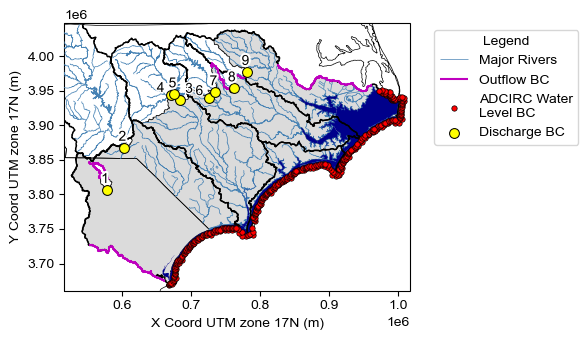

In [19]:
plt_bc_loc_map = True
if plt_bc_loc_map is True:
    wkt = mod.grid['dep'].raster.crs.to_wkt()
    utm_zone = mod.grid['dep'].raster.crs.to_wkt().split("UTM zone ")[1][:3]
    utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
    extent = np.array(mod.region.buffer(10000).total_bounds)[[0, 2, 1, 3]]

    fig, ax = plt.subplots(
        nrows=1, ncols=1,
        figsize=(6.5, 3.5),
        subplot_kw={'projection': utm},
        tight_layout=True)

    # Plot background/geography layers
    mod.region.plot(ax=ax, color='lightgrey', edgecolor='black',
                    linewidth=0.5, zorder=1, alpha=0.8, label='Domain')
    states.plot(ax=ax, color='none', edgecolor='black',
                linewidth=0.5, linestyle='-', zorder=2, alpha=1)
    major_rivers.plot(ax=ax, color='steelblue', edgecolor='none',
                      linewidth=0.5, linestyle='-', zorder=3, alpha=1, label='Major Rivers')
    coastal_wb.plot(ax=ax, color='darkblue', edgecolor='none',
                    linewidth=0.75, linestyle='-', zorder=3, alpha=1, label='Coastal Water Bodies')
    # lpd_riv.plot(ax=ax, color='steelblue', edgecolor='steelblue',
    #              linewidth=0.5, linestyle='-', zorder=3, alpha=1)
    basins.plot(ax=ax, color='none', edgecolor='black', linewidth=1,
                linestyle='-', zorder=3, alpha=1, label='HUC6 Basins')
    gdf_msk3.plot(ax=ax, zorder=3, label="Outflow BC", color='m')
    bzs.plot(ax=ax, color='red', zorder=3, marker='o', markersize=15, edgecolor='black',
             linewidth=0.5, label='ADCIRC Water\nLevel BC')
    dis.plot(ax=ax, color='yellow', zorder=3, marker='o', markersize=50,
             edgecolor='black', linewidth=0.75, label='Discharge BC')

    for label, grow in dis.iterrows():
        x, y = grow.geometry.x, grow.geometry.y
        if label == 6 or label == 4:
            ann_kwargs = dict(
                xytext=(-10, 2),
                textcoords="offset points",
                zorder=4,
                path_effects=[
                    patheffects.Stroke(linewidth=2, foreground="w", alpha=1),
                    patheffects.Normal(),
                ],
            )
        elif label == 3:
            ann_kwargs = dict(
                xytext=(4, 5),
                textcoords="offset points",
                zorder=4,
                path_effects=[
                    patheffects.Stroke(linewidth=2, foreground="w", alpha=1),
                    patheffects.Normal(),
                ],
            )
        else:
            ann_kwargs = dict(
                xytext=(-4, 5),
                textcoords="offset points",
                zorder=4,
                path_effects=[
                    patheffects.Stroke(linewidth=3, foreground="w", alpha=1),
                    patheffects.Normal(),
                ],
            )
        ax.annotate(f'{label}', xy=(x, y), **ann_kwargs)

    minx, miny, maxx, maxy = basins.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    legend_kwargs0 = dict(
        bbox_to_anchor=(1.05, 1),
        title="Legend",
        loc="upper left",
        frameon=True,
        prop=dict(size=10),
    )
    ax.legend(**legend_kwargs0)

    # Add title and save figure
    ax.set_extent(extent, crs=utm)
    ax.set_title('')
    ax.set_ylabel(f"Y Coord UTM zone {utm_zone} (m)")
    ax.yaxis.set_visible(True)
    ax.set_xlabel(f"X Coord UTM zone {utm_zone} (m)")
    ax.xaxis.set_visible(True)
    ax.ticklabel_format(style='sci', useOffset=False)
    ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.savefig(os.path.join(mod.root, 'figs', 'boundary_conditions.png'), bbox_inches='tight', dpi=255)
    #plt.close()

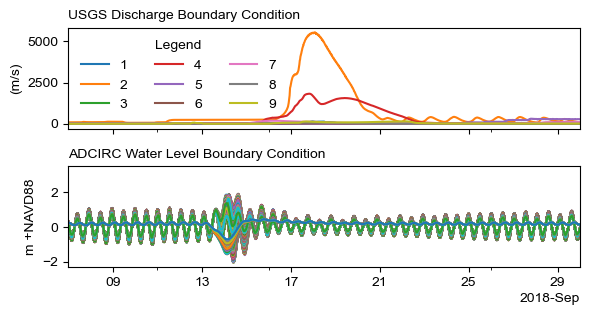

In [20]:
plt_timeseries = True
if plt_timeseries is True:
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3.25), tight_layout=True, sharex=True)

    # convert to Single index dataframe (bar plots don't work with xarray)
    bnd_type = 'dis'
    da = mod.forcing[bnd_type]
    df = da.to_pandas().transpose()
    df.index = mdates.date2num(df.index)
    df.plot(ax=axs[0],
            label=False)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    axs[0].xaxis.set_major_locator(locator)
    axs[0].xaxis.set_major_formatter(formatter)
    # axs[0].set_yscale('log')
    # axs[0].set_ylim((-1, 2000))
    axs[0].set_ylabel('(m/s)')
    # axs[0].set_aspect('equal')
    axs[0].set_title('')
    axs[0].set_title('USGS Discharge Boundary Condition', loc='left', fontsize=10)

    legend_kwargs0 = dict(
        ncol=3,
        # bbox_to_anchor=(1.05, 1),
        title="Legend",
        loc="best",
        frameon=False,
        # prop=dict(size=10),
    )
    axs[0].legend(**legend_kwargs0)

    bnd_type = 'bzs'
    da = mod.forcing[bnd_type]
    df = da.to_pandas().transpose()
    df.index = mdates.date2num(df.index)
    df.plot(ax=axs[1],
            label=False,
            legend=False)
    axs[1].set_ylim((-2.3, 3.5))
    axs[1].xaxis.set_major_locator(locator)
    axs[1].xaxis.set_major_formatter(formatter)
    axs[1].set_ylabel('m +NAVD88')
    # axs[1].set_aspect('equal')
    axs[1].set_title('')
    axs[1].set_title('ADCIRC Water Level Boundary Condition', loc='left', fontsize=10)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.savefig(os.path.join(mod.root, 'figs', 'boundary_conditions_timeseries.png'), bbox_inches='tight',
                dpi=225)
    #plt.close()

In [21]:
''' Model Meteo Boundary Conditions Figure '''
# Load and calculate total precipitation
precip = mod.forcing['precip_2d']
precip_total = precip.sum(dim='time')

# Load and calculate max wind speed
wind_u = mod.forcing['wind_u']
wind_v = mod.forcing['wind_v']
wind_spd = ((wind_u ** 2) + (wind_u ** 2)) ** 0.5
max_wind_spd = wind_spd.max(dim='time')

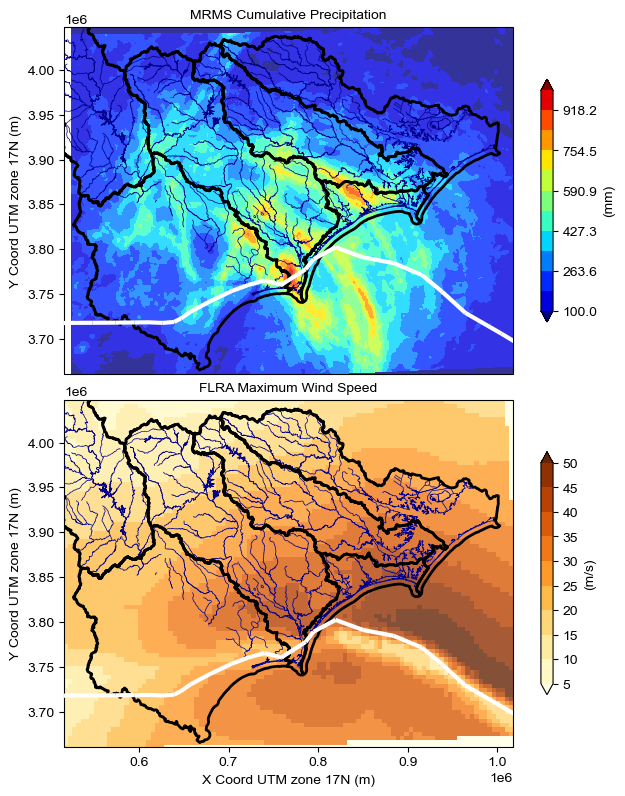

In [24]:
plt_meteo_map = True
if plt_meteo_map is True:
    wkt = mod.grid['dep'].raster.crs.to_wkt()
    utm_zone = mod.grid['dep'].raster.crs.to_wkt().split("UTM zone ")[1][:3]
    utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
    extent = np.array(mod.region.buffer(10000).total_bounds)[[0, 2, 1, 3]]

    fig, axs = plt.subplots(
        nrows=2, ncols=1,
        figsize=(6.5, 8),
        subplot_kw={'projection': utm},
        tight_layout=True, sharex=True, sharey=False)

    # Precipitation!!!
    cmap = mpl.cm.jet
    bounds = np.linspace(start=100, stop=1000, num=12)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
    precip_total.plot(ax=axs[0],
                      cmap=cmap,
                      norm=norm,
                      add_colorbar=False,
                      zorder=2,
                      alpha=0.8,
                      )
    # Plot background/geography layers
    major_rivers.plot(ax=axs[0], color='darkblue', edgecolor='none', linewidth=0.5,
                      linestyle='-', zorder=3, alpha=1, label='Major Rivers')
    # lpd_riv.plot(ax=axs[0], color='darkblue', edgecolor='darkblue', linewidth=0.5,
    #              linestyle='-', zorder=3, alpha=1)
    basins.plot(ax=axs[0], color='none', edgecolor='black', linewidth=2,
                linestyle='-', zorder=3, alpha=1, label='HUC6 Basins')
    tc_tracks[tc_tracks['NAME'] == storm].plot(ax=axs[0], color='white', edgecolor='black',
                                               label='TC Track',
                                               linewidth=3, linestyle='-', zorder=3, alpha=1)

    minx, miny, maxx, maxy = basins.total_bounds
    axs[0].set_xlim(minx, maxx)
    axs[0].set_ylim(miny, maxy)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm,
                 ax=axs[0],
                 shrink=0.7,
                 extend='both',
                 spacing='uniform',
                 label='(mm)')

    axs[0].set_extent(extent, crs=utm)
    axs[0].set_title('')
    axs[0].set_title('MRMS Cumulative Precipitation', loc='center')
    axs[0].set_ylabel(f"Y Coord UTM zone {utm_zone} (m)")
    axs[0].yaxis.set_visible(True)
    axs[0].set_xlabel(f"X Coord UTM zone {utm_zone} (m)")
    axs[0].xaxis.set_visible(False)
    axs[0].ticklabel_format(style='sci', useOffset=False)
    axs[0].set_aspect('equal')

    # WIND
    cmap = mpl.cm.YlOrBr
    bounds = np.linspace(start=5, stop=50, num=10)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
    max_wind_spd.plot(ax=axs[1],
                      cmap=cmap,
                      norm=norm,
                      add_colorbar=False,
                      zorder=2,
                      alpha=0.8
                      )
    # Plot background/geography layers
    major_rivers.plot(ax=axs[1], color='darkblue', edgecolor='none', linewidth=0.5,
                      linestyle='-', zorder=3, alpha=1, label='Major Rivers')
    # lpd_riv.plot(ax=axs[1], color='darkblue', edgecolor='darkblue',
    #              linestyle='-', zorder=3, alpha=1)
    basins.plot(ax=axs[1], color='none', edgecolor='black', linewidth=2,
                linestyle='-', zorder=3, alpha=1, label='HUC6 Basins')
    tc_tracks[tc_tracks['NAME'] == storm].plot(ax=axs[1], color='white', edgecolor='black',
                                               label='TC Track',
                                               linewidth=3, linestyle='-', zorder=3, alpha=1)

    minx, miny, maxx, maxy = basins.total_bounds
    axs[1].set_xlim(minx, maxx)
    axs[1].set_ylim(miny, maxy)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm,
                 ax=axs[1],
                 shrink=0.7,
                 extend='both',
                 spacing='uniform',
                 label='(m/s)')

    # Add title and save figure
    axs[1].set_extent(extent, crs=utm)
    axs[1].set_title('')
    axs[1].set_title('FLRA Maximum Wind Speed', loc='center')
    axs[1].set_ylabel(f"Y Coord UTM zone {utm_zone} (m)")
    axs[1].yaxis.set_visible(True)
    axs[1].set_xlabel(f"X Coord UTM zone {utm_zone} (m)")
    axs[1].xaxis.set_visible(True)
    axs[1].ticklabel_format(style='sci', useOffset=False)
    axs[1].set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.savefig(os.path.join(mod.root, 'figs', 'meteo.png'), bbox_inches='tight',
                dpi=255)
    #plt.close()